In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dimod
import datetime
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from dimod.reference.samplers import SimulatedAnnealingSampler

In [ ]:
# Data preprocessing

# Upload data in dataframes
df_train = pd.read_csv('data/KDDTrain+.txt', header=None)
df_test = pd.read_csv('data/KDDTest+.txt', header=None)

# Adjust parameters
df_train = df_train.iloc[:, :-1]
df_test = df_test.iloc[:, :-1]

# Add oficial columns names
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]
df_train.columns = column_names
df_test.columns = column_names

# Show some info
print("Train dataset sample:")
display(df_train.head())

print("\nTest dataset sample:")
display(df_test.head())

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

print("Train dataset info:")
print(df_train.info())

print("\nTest dataset info:")
print(df_test.info())

print("\nDistribution of attack types in training set:")
print(df_train['label'].value_counts())

print("\nDistribution of attack types in test set:")
print(df_test['label'].value_counts())

print("Labels in train:\n", df_train['label'].value_counts())
print("Labels in test:\n", df_test['label'].value_counts())


Train dataset sample:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal



Test dataset sample:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


Train shape: (125973, 42)
Test shape: (22544, 42)
Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  i

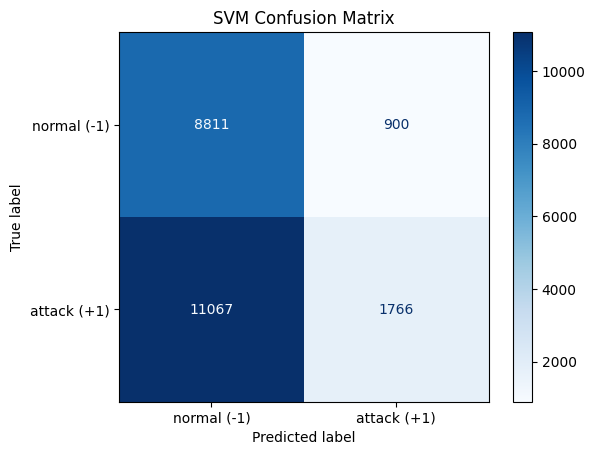

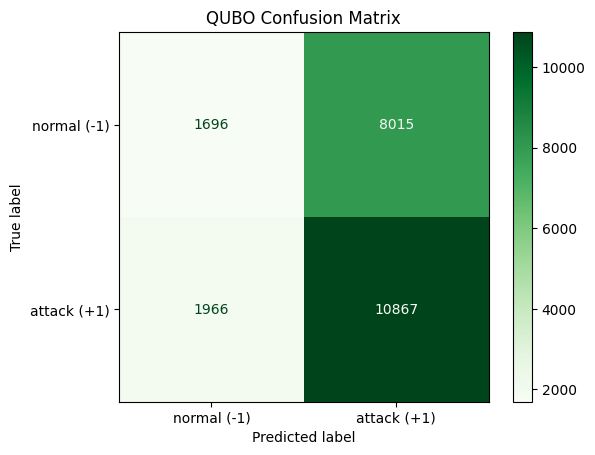

✅ Results saved.


In [ ]:
# Data processing
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Binary converssion of labels
df_train["label"] = df_train["label"].apply(lambda x: -1 if x == "normal" else 1)
df_test["label"] = df_test["label"].apply(lambda x: -1 if x == "normal" else 1)

# Features selection of the dataset that will train the model and normalisation
var_1 = "dst_host_srv_diff_host_rate"
var_2 = "dst_host_same_src_port_rate"
features = [var_1, var_2]
X_train = df_train[features].values
y_train = df_train["label"].values
X_test = df_test[features].values
y_test = df_test["label"].values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM train and evaluation
clf = SVC(kernel="linear", C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred)
prec_svm = precision_score(y_test, y_pred)
rec_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
cm_svm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["normal (-1)", "attack (+1)"])
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

# QUBO formulation (6 balanced points, 3 bits)
np.random.seed(42) # Reproducibility
num_per_class = 3
idx_normal = np.random.choice(np.where(y_train == -1)[0], size=num_per_class, replace=False)
idx_attack = np.random.choice(np.where(y_train == 1)[0], size=num_per_class, replace=False)
idx_total = np.concatenate([idx_normal, idx_attack])

X_sub = X_train[idx_total]
y_sub = y_train[idx_total]
m = len(X_sub)
b = 3

# Q matrix construction
K = X_sub @ X_sub.T
Q = {}

for i in range(m):
    for j in range(m):
        coef = -0.5 * y_sub[i] * y_sub[j] * K[i,j]
        for k in range(b):
            for l in range(b):
                iik, jjk = i*b+k, j*b+l
                Q[(iik,jjk)] = Q.get((iik,jjk),0) + coef*(2**k)*(2**l)/(2**b-1)**2
for i in range(m):
    for k in range(b):
        iik = i*b+k
        Q[(iik,iik)] = Q.get((iik,iik),0) + (2**k)/(2**b-1)

# QUBO resolution
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
neal_samp = SimulatedAnnealingSampler().sample(bqm, num_reads=1000).first.sample
alphas_ne = [sum(neal_samp[i*b + k]*(2**k) for k in range(b))/(2**b-1) for i in range(m)]
w_ne = sum(alphas_ne[i]*y_sub[i]*X_sub[i] for i in range(m))
pred_ne = np.sign(X_test @ w_ne)
mask_ne = pred_ne != 0
acc_ne  = accuracy_score(y_test[mask_ne], pred_ne[mask_ne])
prec_ne = precision_score(y_test[mask_ne], pred_ne[mask_ne])
rec_ne  = recall_score(y_test[mask_ne], pred_ne[mask_ne])
f1_ne   = f1_score(y_test[mask_ne], pred_ne[mask_ne])
cm_ne = confusion_matrix(y_test, pred_ne, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ne, display_labels=["normal (-1)", "attack (+1)"])
disp.plot(cmap='Greens')
plt.title("QUBO Confusion Matrix")
plt.show()

with open("experimental_results.txt","a") as f:
    f.write(f"\n--- Comparison ({datetime.datetime.now()}) ---\n")
    f.write(f"Features: {var_1}, {var_2}\n")
    f.write("SVM:\n")
    f.write(f" Acc: {acc_svm:.4f}, Prec: {prec_svm:.4f}, Rec: {rec_svm:.4f}, F1: {f1_svm:.4f}\n")
    f.write("QUBO Simulated Annealing:\n")
    f.write(f" Acc: {acc_ne:.4f}, Prec: {prec_ne:.4f}, Rec: {rec_ne:.4f}, F1: {f1_ne:.4f}\n")
    f.write("-"*40+"\n")
print("✅ Results saved.")


# Save the confusion matrix
svm_output_dir = './outputs'
os.makedirs(svm_output_dir, exist_ok=True)
svm_output_path = os.path.join(svm_output_dir, 'svm_confusion_matrix.png')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["normal (-1)", "attack (+1)"])
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.savefig(svm_output_path)
plt.close()
qubo_output_dir = './outputs'
os.makedirs(qubo_output_dir, exist_ok=True)
qubo_output_path = os.path.join(qubo_output_dir, 'qubo_confusion_matrix.png')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ne, display_labels=["normal (-1)", "attack (+1)"])
disp.plot(cmap='Greens')
plt.title("QUBO Confusion Matrix")
plt.savefig(qubo_output_path)
plt.close()
print(f"SVM confusion matrix saved at: {svm_output_path}")
print(f"QUBO confusion matrix saved at: {qubo_output_path}")


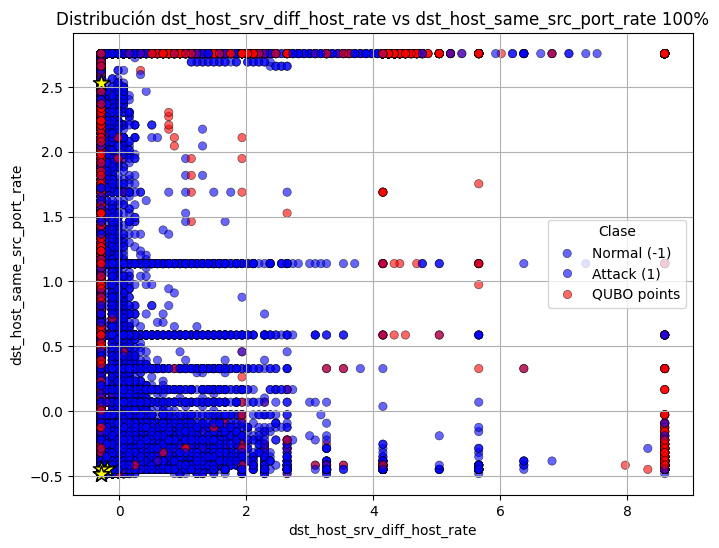

Saved in: outputs/scatter_dst_host_srv_diff_host_rate_dst_host_same_src_port_rate_20250715_202658.png


In [9]:
# Create a dir to save the plots
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
df_normalized = pd.DataFrame(X_train, columns=[var_1, var_2])
df_normalized["label"] = y_train

# Randomly select 3 points from each class for the scatterplot
idx_normal = np.where(y_train == -1)[0]
idx_attack = np.where(y_train == 1)[0]

np.random.seed(42)  # For reproducibility
idx_normal_sel = np.random.choice(idx_normal, size=3, replace=False)
idx_attack_sel = np.random.choice(idx_attack, size=3, replace=False)
idx_total = np.concatenate([idx_normal_sel, idx_attack_sel])

X_sub = X_train[idx_total]
y_sub = y_train[idx_total]

# Scatterplot creation already normalized
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_normalized, x=var_1, y=var_2, hue="label",
                palette={-1: "blue", 1: "red"}, alpha=0.6, edgecolor="k")

# QUBO points
plt.scatter(X_sub[:, 0], X_sub[:, 1], c="yellow", edgecolors="black",
            s=150, marker="*", label="QUBO points")


plt.title(f"Distribución {var_1} vs {var_2} 100%")
plt.xlabel(var_1)
plt.ylabel(var_2)
plt.grid(True)
plt.legend(title="Clase", labels=["Normal (-1)", "Attack (1)", "QUBO points"])

# Automatically save the plot with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{output_dir}/scatter_{var_1}_{var_2}_{timestamp}.png"
plt.savefig(filename)
plt.show()

print(f"Saved in: {filename}")

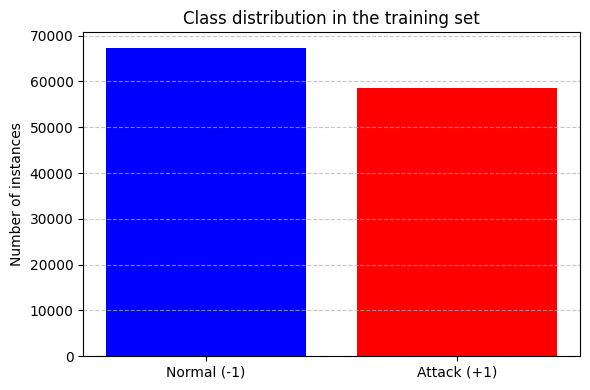

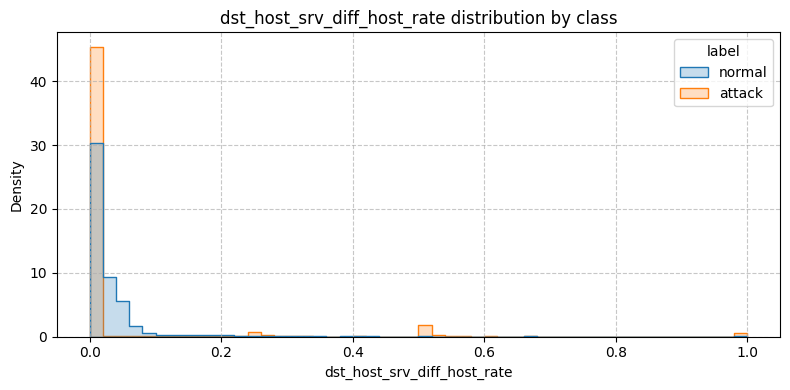

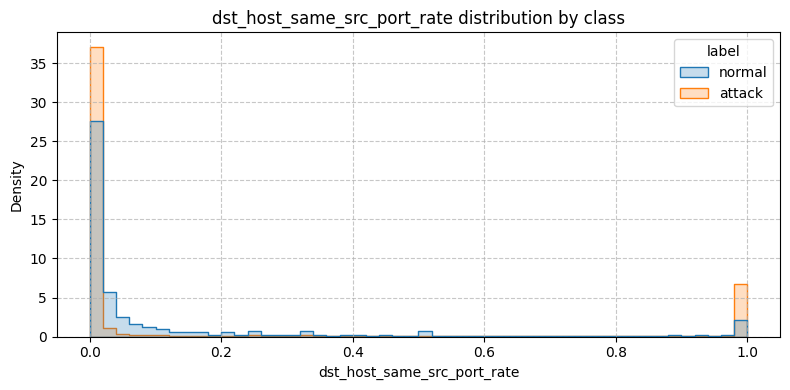

('./outputs/class_distribution.png',
 './outputs/dst_host_srv_diff_host_rate_distribution.png',
 './outputs/dst_host_same_src_port_rate_distribution.png')

In [16]:
# More graphics
labels, counts = np.unique(y_train, return_counts=True)
label_names = ['Normal (-1)', 'Attack (+1)']
counts_dict = dict(zip(labels, counts))
plt.figure(figsize=(6, 4))
plt.bar(label_names, counts, color=['blue', 'red'])
plt.title("Class distribution in the training set")
plt.ylabel("Number of instances")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the class distribution plot
class_dist_path = './outputs/class_distribution.png'
plt.savefig(class_dist_path)
plt.show()
plt.close()

# Temporary DataFrame for plotting
df_plot = pd.DataFrame({
    var_1: df_train[var_1],
    var_2: df_train[var_2],
    'label': df_train['label'].map(lambda x: 'normal' if x == -1 else 'attack')
})

plt.figure(figsize=(8, 4))
sns.histplot(data=df_plot, x=var_1, hue='label', bins=50, element='step', stat='density', common_norm=False)
plt.title(var_1 + ' distribution by class')
plt.xlabel(var_1)
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the var_1 distribution plot
var_1_dist_path = f'./outputs/{var_1}_distribution.png'
plt.savefig(var_1_dist_path)
plt.show()
plt.close()

plt.figure(figsize=(8, 4))
sns.histplot(data=df_plot, x=var_2, hue='label', bins=50, element='step', stat='density', common_norm=False)
plt.title(var_2 + ' distribution by class')
plt.xlabel(var_2)
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the var_2 distribution plot
var_2_dist_path = f'./outputs/{var_2}_distribution.png'
plt.savefig(var_2_dist_path)
plt.show()
plt.close()

# Return the paths to the saved images
class_dist_path, var_1_dist_path, var_2_dist_path


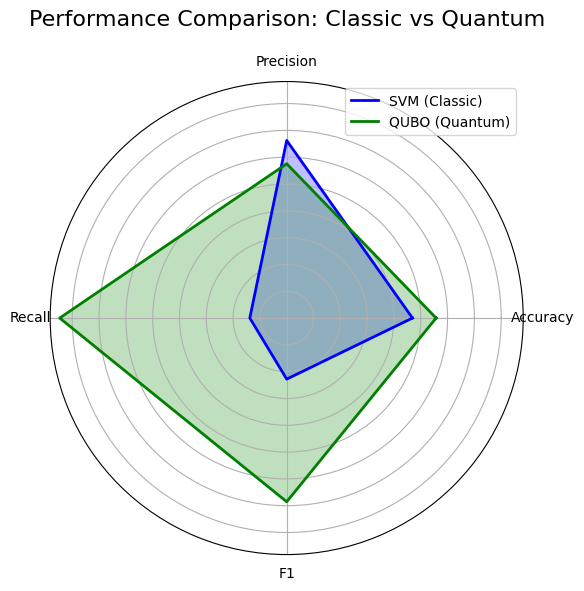

'./outputs/radar_comparison.png'

In [17]:
# Example data: Results from SVM (classic) and QUBO (quantum)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']  # The metrics to compare
svm_scores = [acc_svm, prec_svm, rec_svm, f1_svm]  # Results from the classic model (SVM)
qubo_scores = [acc_ne, prec_ne, rec_ne, f1_ne]    # Results from the quantum model (QUBO)

# Normalize the data so all scores are on the same scale
scores = [svm_scores, qubo_scores]

# Number of metrics
num_metrics = len(metrics)

# Angles for each axis of the radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Close the chart by connecting the last point to the first
scores[0].append(scores[0][0])
scores[1].append(scores[1][0])
angles.append(angles[0])

# Create the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the results for the classic model (SVM)
ax.plot(angles, scores[0], color='blue', linewidth=2, label='SVM (Classic)')

# Plot the results for the quantum model (QUBO)
ax.plot(angles, scores[1], color='green', linewidth=2, label='QUBO (Quantum)')

# Fill the area under the lines
ax.fill(angles, scores[0], color='blue', alpha=0.25)
ax.fill(angles, scores[1], color='green', alpha=0.25)

# Remove labels for the radial axis
ax.set_yticklabels([])

# Set the metric names as labels on the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Set the title of the chart
plt.title('Performance Comparison: Classic vs Quantum', size=16, y=1.1)

# Display the legend for the two models
ax.legend(loc='upper right')

# Save the radar chart
radar_output_path = './outputs/radar_comparison.png'
plt.tight_layout()
plt.savefig(radar_output_path)

# Show the radar chart
plt.show()

# Return the path of the saved image
radar_output_path
